# Ship Image Classification Deep Learning Project
### Syracuse Univeristy
By Blake Zurman



This Dataset is taken from Deep Learning Hackathon organised by Analytics Vidhya

Here is the kaggle link for this data
https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets/data

In [ ]:
from IPython import get_ipython
from IPython.display import display
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

path = kagglehub.dataset_download("arpitjain007/game-of-deep-learning-ship-datasets")

print("Path to dataset files:", path)

train_csv_path = os.path.join(path, 'train', 'train.csv')
main_path = os.path.join(path, 'train', 'images')

organized_train_dir = os.path.join('/kaggle/working/', 'organized_train')

main_df = pd.read_csv(train_csv_path)

paths = os.listdir(main_path)

main_df['path'] = main_path + '/' + main_df['image']

main_df.head()

if not os.path.exists(organized_train_dir):
    os.makedirs(organized_train_dir)

categories = list(main_df['category'])
categorys = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}
classes = []

for category in categories:
    classes.append(categorys[category])

main_df['classes'] = classes

test_csv_path = os.path.join(path, 'test_ApKoW4T.csv')
test_df = pd.read_csv(test_csv_path)

test_df['path'] = test_df['image'].apply(lambda x: os.path.join(main_path, x))

Path to dataset files: /kaggle/input/game-of-deep-learning-ship-datasets


EDA

Here, I'm looking at the data distributions, as well as the train and test data using PIL image

Some of the images are all greenish yellow and blue, I can only assume these are night vision images, or most likely, just poorly colored photos to try and throw the model off (as this is a hacakthon data set).

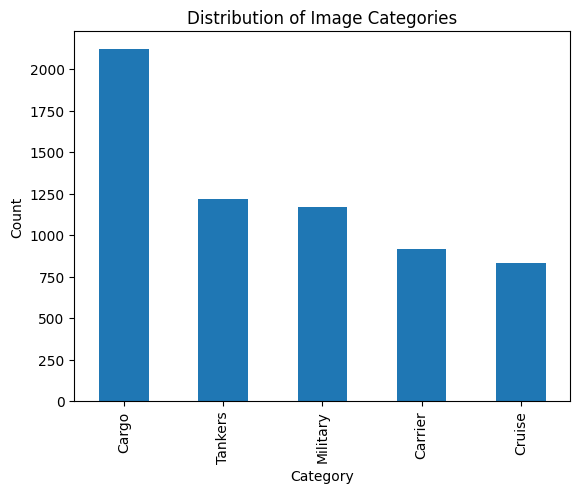

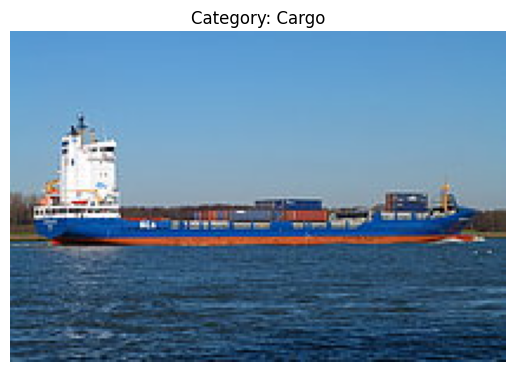

Train samples:  6252
Test samples:  2680


In [ ]:
# Display the distribution of classes
main_df['classes'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Display a sample image and its category
sample_image_path = main_df['path'][0]
sample_category = main_df['classes'][0]
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for matplotlib
plt.imshow(image)
plt.title(f'Category: {sample_category}')
plt.axis('off')
plt.show()

# Print sample counts (this was the code causing the error)
print('Train samples: ', len(main_df))
print('Test samples: ', len(test_df))

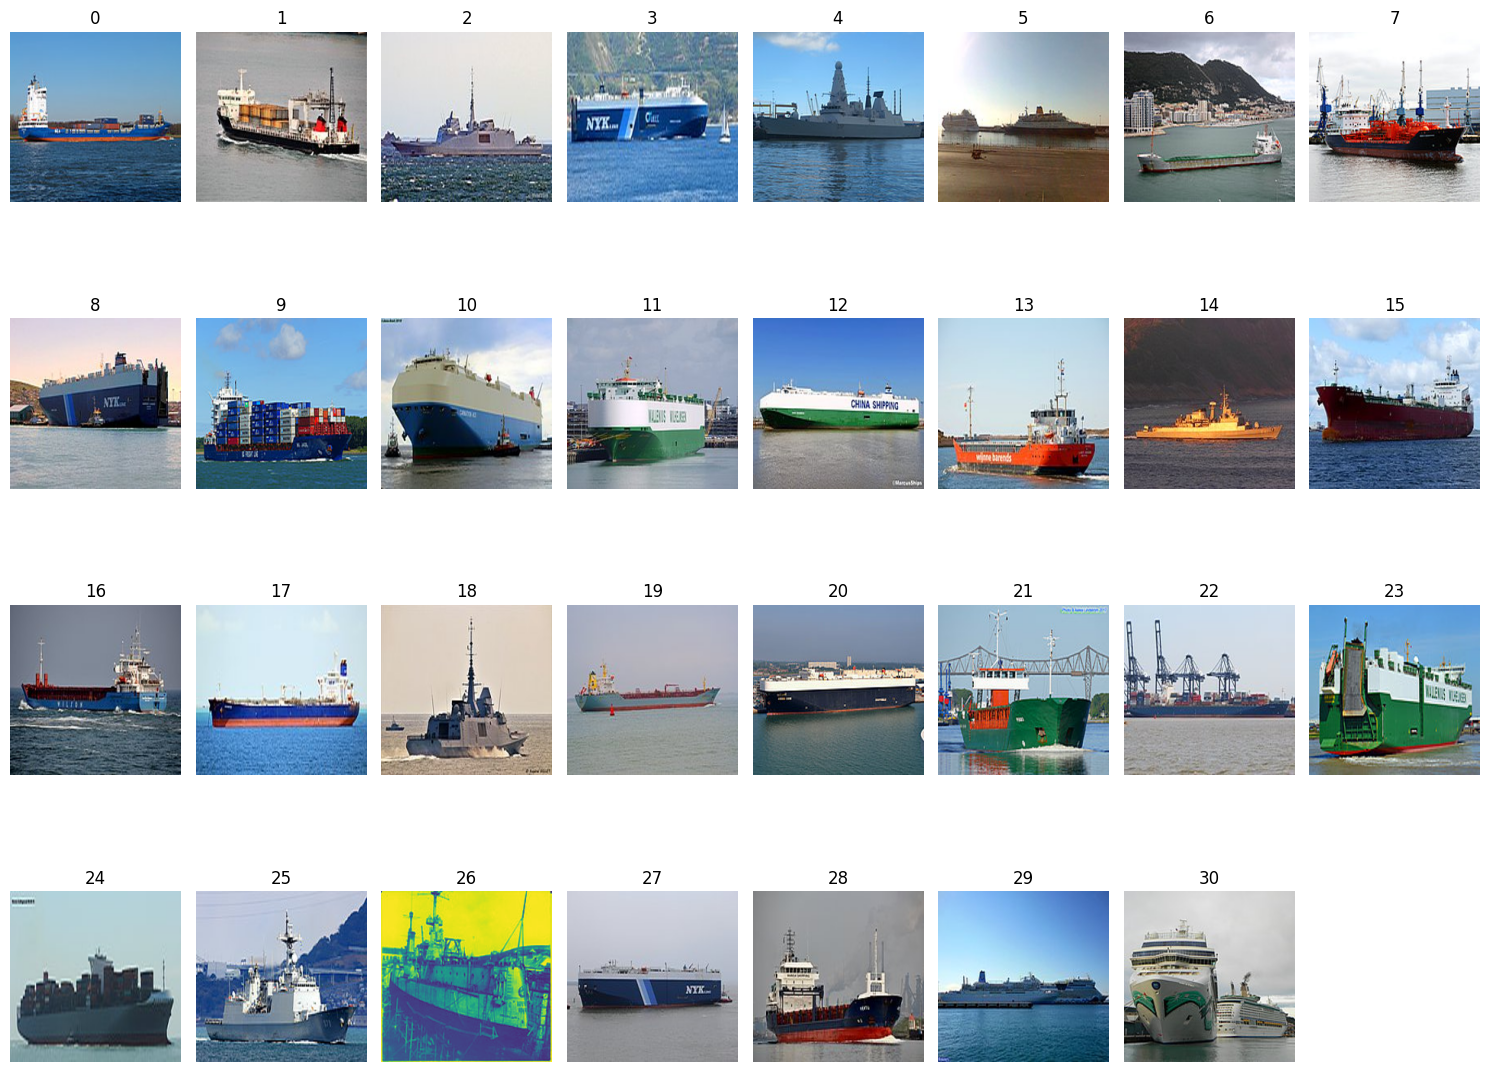

In [ ]:
from PIL import Image

plt.figure(figsize = (15,12))
for idx,image_path in enumerate(main_df['path']):
    if idx==31:
        break
    plt.subplot(4,8,idx+1)
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)
plt.tight_layout()
plt.show()

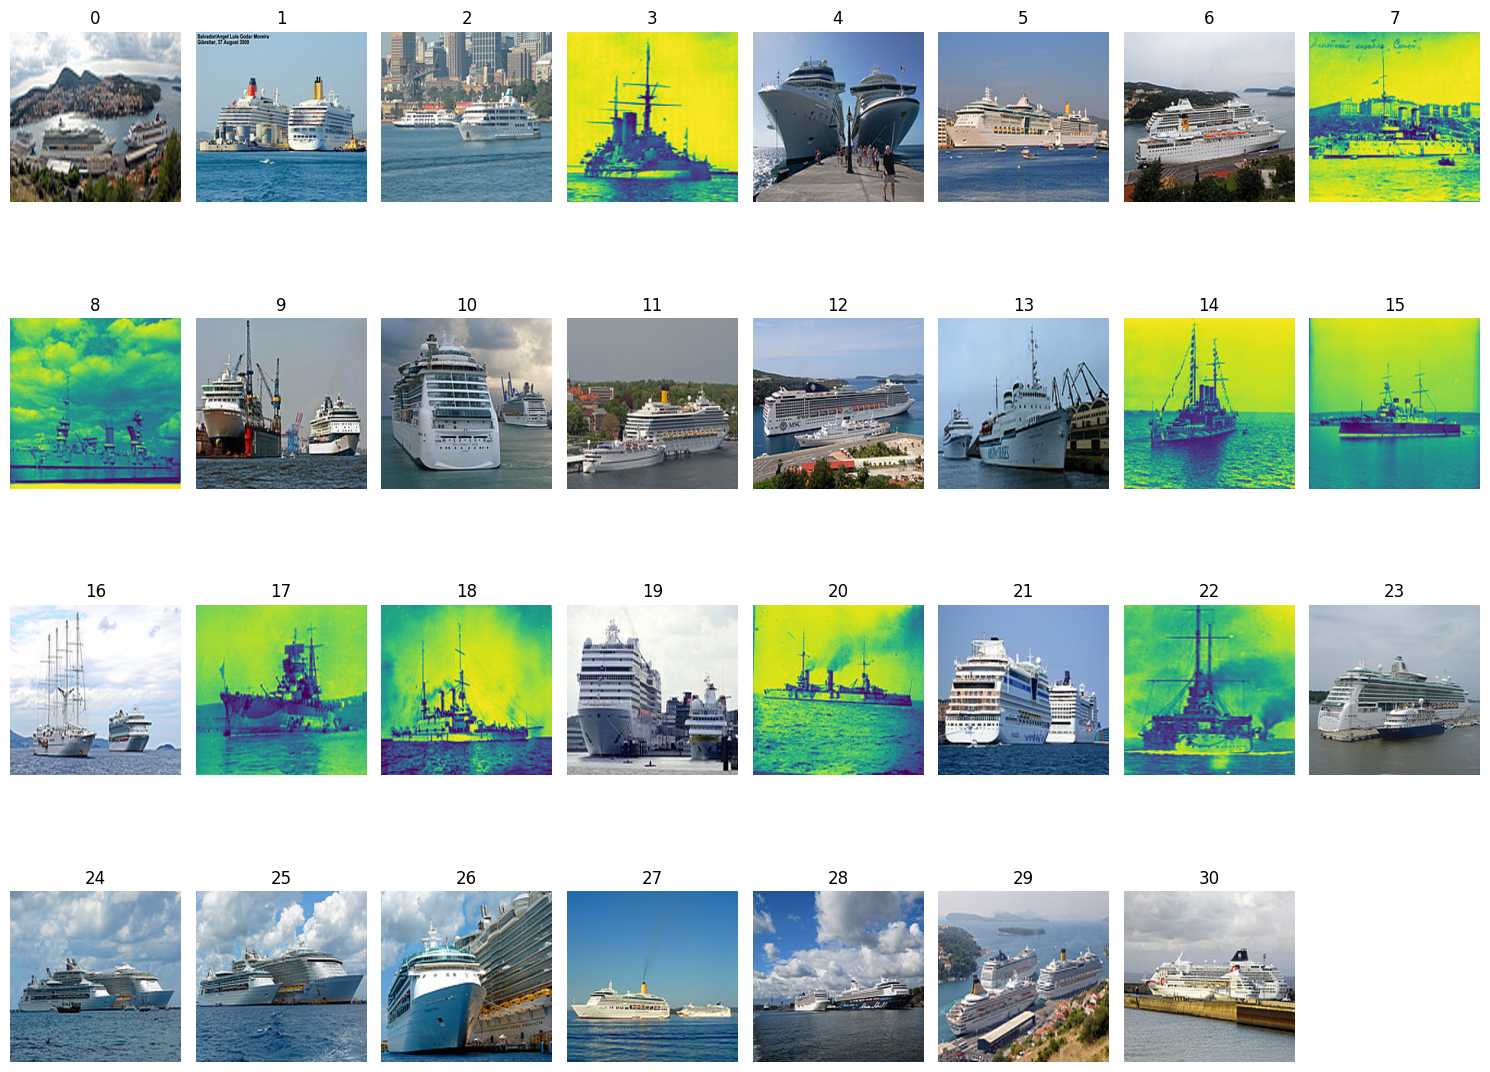

In [ ]:
plt.figure(figsize = (15,12))
for idx,image_path in enumerate(test_df['path']):
    if idx==31:
        break
    plt.subplot(4,8,idx+1)
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)
plt.tight_layout()
plt.show()

Set up Image Data Generators for Training and Validation

In [ ]:
import tensorflow as tf

img_height = 224
img_width = 224

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=main_df,
    x_col='path',
    y_col='classes',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=main_df,
    x_col='path',
    y_col='classes',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5002 validated image filenames belonging to 5 classes.
Found 1250 validated image filenames belonging to 5 classes.


Build and Train a Simple CNN Model

In [12]:
# Build a simple convolutional neural network (CNN) model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(categorys), activation='softmax') # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10 # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Evaluate the model (optional, you can do this after training)
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 777s 5s/step - accuracy: 0.3272 - loss: 1.9894 - val_accuracy: 0.5537 - val_loss: 1.1620
Epoch 2/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - accuracy: 0.5938 - loss: 1.2061

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 514ms/step - accuracy: 0.5938 - loss: 1.2061 - val_accuracy: 0.5473 - val_loss: 1.1599
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 798s 5s/step - accuracy: 0.5518 - loss: 1.1132 - val_accuracy: 0.6202 - val_loss: 0.9527
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - accuracy: 0.7188 - loss: 0.7785 - val_accuracy: 0.6106 - val_loss: 0.9869
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 742s 5s/step - accuracy: 0.6257 - loss: 0.9318 - val_accuracy: 0.6603 - val_loss: 0.8631
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 274ms/step - accuracy: 0.6875 - loss: 0.7041 - val_accuracy: 0.6707 - val_loss: 0.8528
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 802s 5s/step - accuracy: 0.6764 - loss: 0.8070 - val_accuracy: 0.6795 - val_loss: 0.8382
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 276ms/step - accuracy: 0.7188 - loss: 0.8448 - val_accuracy: 0.6755 - val_loss: 0.8477
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 738s 5s/step - accuracy: 0.7210 - loss: 0.7040 - val_accurac

Build and Train a Transfer Learning Model (VGG16)

In [13]:
import tensorflow as tf

base_model = tf.keras.applications.VGG16(weights='imagenet',
                                         include_top=False,
                                         input_shape=(img_height, img_width, 3))

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(categorys), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 4003s 26s/step - accuracy: 0.5528 - loss: 2.1929 - val_accuracy: 0.7708 - val_loss: 0.5645
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 785s 5s/step - accuracy: 0.8125 - loss: 0.4603 - val_accuracy: 0.7788 - val_loss: 0.5458
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 3927s 25s/step - accuracy: 0.8370 - loss: 0.4257 - val_accuracy: 0.8373 - val_loss: 0.4528
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 785s 5s/step - accuracy: 0.8438 - loss: 0.4693 - val_accuracy: 0.8261 - val_loss: 0.4437
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 3982s 25s/step - accuracy: 0.8458 - loss: 0.3947 - val_accuracy: 0.8518 - val_loss: 0.3939
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 813s 5s/step - accuracy: 0.8438 - loss: 0.3408 - val_accuracy: 0.8622 - val_loss: 0.3847
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 3975s 25s/step - accuracy: 0.8881 - loss: 0.2874 - val_accuracy: 0.8654 - val_loss: 0.3660
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━